In [28]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from dataflow import df_train, df_test, df_geography, df_product

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Chuyển cột Date sang kiểu datetime
df_train['Date'] = pd.to_datetime(df_train['Date'], errors='coerce')
df_test['Date'] = pd.to_datetime(df_test['Date'], errors='coerce')

# Xử lý lỗi nếu có giá trị NaT
df_train.dropna(subset=['Date'], inplace=True)
df_test.dropna(subset=['Date'], inplace=True)

# Tính số ngày kể từ ngày đầu tiên trong tập train
min_date = df_train['Date'].min()
df_train['Date'] = (df_train['Date'] - min_date).dt.days
df_test['Date'] = (df_test['Date'] - min_date).dt.days

# Chia df_train thành train (80%) và val (20%)
df_train, df_val = train_test_split(df_train, test_size=0.2, shuffle=True, random_state=42)

# Chọn features và labels
features = ['ProductID', 'Date', 'Zip', 'COGS']
targets = ['Units', 'Revenue']

# Chuẩn hóa dữ liệu
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(df_train[features])
X_val = scaler_X.transform(df_val[features])
X_test = scaler_X.transform(df_test[features])  # Dùng tập test để dự đoán

y_train = scaler_y.fit_transform(df_train[targets])
y_val = scaler_y.transform(df_val[targets])
y_test = scaler_y.transform(df_test[targets])  # Dùng để đánh giá mô hình


In [30]:
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 20  # Dùng 20 ngày trước đó để dự đoán ngày tiếp theo

X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)  # Tập này sẽ dùng để dự đoán


In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Xây dựng mô hình LSTM
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(y_train_seq.shape[1])  # Đầu ra có số chiều bằng số lượng target
])

# Compile mô hình
model.compile(optimizer='adam', loss='mse')

# Huấn luyện mô hình
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=3, batch_size=32
)


Epoch 1/3
22539/22539 ━━━━━━━━━━━━━━━━━━━━ 267s 12ms/step - loss: 1.4900e-04 - val_loss: 1.2271e-04
Epoch 2/3
22539/22539 ━━━━━━━━━━━━━━━━━━━━ 209s 9ms/step - loss: 1.2180e-04 - val_loss: 1.3228e-04
Epoch 3/3
22539/22539 ━━━━━━━━━━━━━━━━━━━━ 208s 9ms/step - loss: 1.2362e-04 - val_loss: 1.2273e-04


In [36]:
# Dự đoán trên tập test
y_pred_scaled = model.predict(X_test_seq)

# Chuyển dữ liệu dự đoán về dạng gốc
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_orig = scaler_y.inverse_transform(y_test_seq)


2334/2334 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [38]:
print(y_pred)

[[1.0099658e+00 5.8668677e+03]
 [1.0099924e+00 5.8666035e+03]
 [1.0099257e+00 5.8662515e+03]
 ...
 [1.0097493e+00 5.8659033e+03]
 [1.0097117e+00 5.8660342e+03]
 [1.0096717e+00 5.8658394e+03]]


In [41]:
import numpy as np

# Kiểm tra xem có NaN trong y_test_orig không
print("🔍 Số lượng NaN trong y_test_orig:", np.isnan(y_test_orig).sum())

# Kiểm tra xem có NaN trong y_pred không
print("🔍 Số lượng NaN trong y_pred:", np.isnan(y_pred).sum())


🔍 Số lượng NaN trong y_test_orig: 41
🔍 Số lượng NaN trong y_pred: 0


In [42]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")  # Thay thế bằng giá trị trung bình

y_test_orig_clean = imputer.fit_transform(y_test_orig)
y_pred_clean = imputer.transform(y_pred)


In [45]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
# Đánh giá mô hình sau khi loại bỏ NaN
for i, metric in enumerate(["Units", "Revenue"]):
    mape = mean_absolute_percentage_error(y_test_orig_clean[:, i], y_pred_clean[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_orig_clean[:, i], y_pred_clean[:, i]))
    r2 = r2_score(y_test_orig_clean[:, i], y_pred_clean[:, i])
    
    print(f"🔹 {metric}:")
    print(f"   ✅ MAPE  = {mape:.4f} (càng nhỏ càng tốt)")
    print(f"   ✅ RMSE  = {rmse:.2f} (càng nhỏ càng tốt)")
    print(f"   ✅ R²    = {r2:.4f} (gần 1 là tốt)")
    print("-" * 40)


🔹 Units:
   ✅ MAPE  = 0.0182 (càng nhỏ càng tốt)
   ✅ RMSE  = 0.23 (càng nhỏ càng tốt)
   ✅ R²    = -0.0033 (gần 1 là tốt)
----------------------------------------
🔹 Revenue:
   ✅ MAPE  = 0.8687 (càng nhỏ càng tốt)
   ✅ RMSE  = 5876.78 (càng nhỏ càng tốt)
   ✅ R²    = -0.1586 (gần 1 là tốt)
----------------------------------------


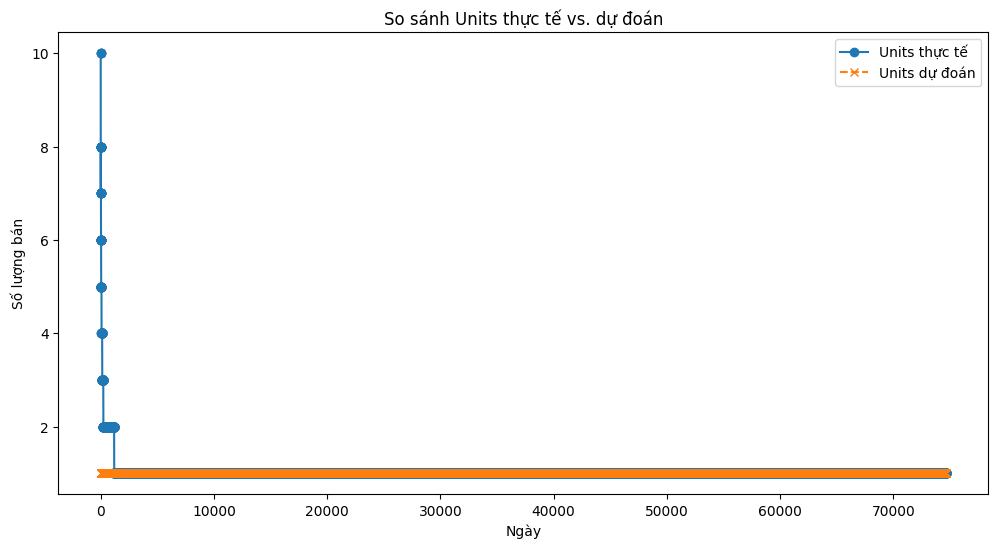

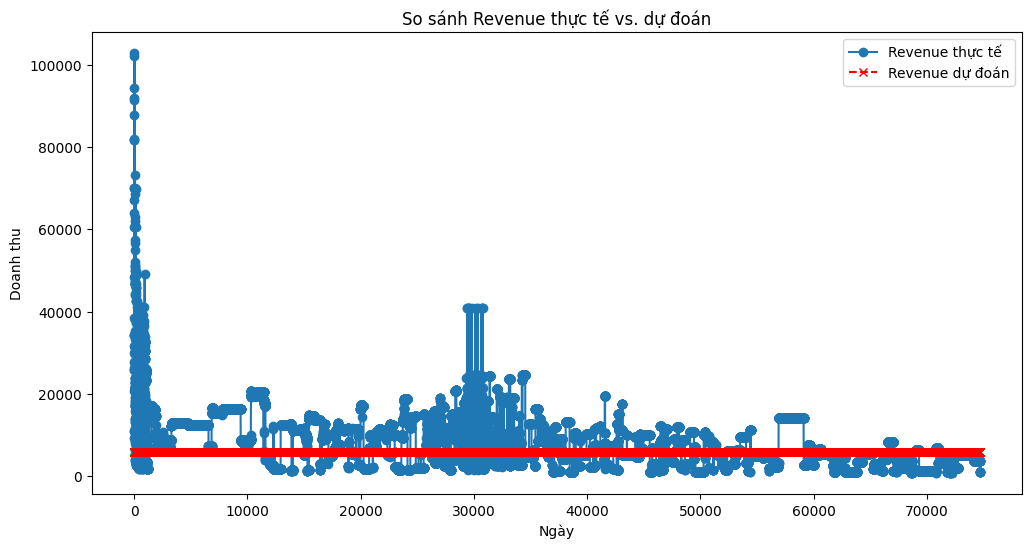

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_orig[:, 0], label="Units thực tế", marker='o')
plt.plot(y_pred[:, 0], label="Units dự đoán", linestyle='dashed', marker='x')
plt.title("So sánh Units thực tế vs. dự đoán")
plt.xlabel("Ngày")
plt.ylabel("Số lượng bán")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test_orig[:, 1], label="Revenue thực tế", marker='o')
plt.plot(y_pred[:, 1], label="Revenue dự đoán", linestyle='dashed', marker='x', color='red')
plt.title("So sánh Revenue thực tế vs. dự đoán")
plt.xlabel("Ngày")
plt.ylabel("Doanh thu")
plt.legend()
plt.show()
